In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

버전 확인

- `python` >= 3.10.12
- `numpy` >= 1.26.0
- `pandas` >= 2.1.1
- `matplotlib` >= 3.8.1
- `seaborn` >= 0.13.0
- `missingno` >= 0.5.2

In [18]:
import sys, matplotlib

print("="*5 ,"나의 라이브러리 버전 확인", "="*5)
print(f"{'python version':15s} <> {sys.version}")
print(f"{'numpy version':15s} <> {np.__version__}")
print(f"{'pandas version':15s} <> {pd.__version__}")
print(f"{'matplotlib version':15s} <> {matplotlib.__version__}")
print(f"{'seaborn version':15s} <> {sns.__version__}")
print(f"{'missingno version':15s} <> {msno.__version__}")

===== 나의 라이브러리 버전 확인 =====
python version  <> 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
numpy version   <> 1.26.3
pandas version  <> 2.1.4
matplotlib version <> 3.8.2
seaborn version <> 0.13.1
missingno version <> 0.5.2


In [19]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}
#df = pd.read_csv('/data/ephemeral/home/level2-dkt-recsys-06/data/train_data.csv', dtype=dtype, parse_dates=['Timestamp'])
df = pd.read_csv('/data/ephemeral/home/level2-dkt-recsys-06/data/augment.csv') #피처 생성 완료된 파일. 직접 생성하려면 아래 셀
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 9.51 s, sys: 1.07 s, total: 10.6 s
Wall time: 10.6 s


In [4]:
'''''''''''''''''''''''''''''
###### FEATURE AUGMENTATION ######

# SolvingTime, CumulativeTime : 해당 문제를 푸는데 걸린 시간(초), 해당 시험지 내에서 해당 문제 전까지 누적 풀이 시간(초)
df['NextTimestamp'] = pd.to_datetime(df.groupby(['userID', 'testId'])['Timestamp'].shift(-1))
df['SolvingTime'] = (df['NextTimestamp'] - df['Timestamp']).dt.total_seconds()
df['CumulativeTime'] = df.groupby(['userID', 'testId'])['SolvingTime'].cumsum()
df = df.drop(columns=['NextTimestamp'])
## Issue : 시험지 내 마지막 문제에 Solvingtime 결측

# Month, DayOfWeek, TimeOfDay : 문제를 푼 달, 요일, 시간대(0~6시는 새벽, 6~12시는 오전, 12~18시는 오후, 18~24시는 밤)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
day_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['DayOfWeek'] = df['DayOfWeek'].map(day_dict)
def label_hour(hour):
    if 0 <= hour < 6:
        return 'Dawn'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Night'
df['TimeOfDay'] = df['Timestamp'].dt.hour.apply(label_hour)


# problems_last7days, problems_last30days, problems_cumulative : User가 해당 문제 푼 시점으로부터 7일 전까지, 30일 전까지, 처음까지 푼 누적 문제 수
df = df.sort_values(['userID', 'Timestamp'])
grouped = df.groupby('userID')
df['problems_cumulative'] = grouped.cumcount()

results = []
for name, group in grouped:
    group['problems_last7days'] = group.rolling('7D', on='Timestamp')['assessmentItemID'].count() - 1
    group['problems_last30days'] = group.rolling('30D', on='Timestamp')['assessmentItemID'].count() - 1
    results.append(group)

df = pd.concat(results)
df['problems_last7days'] = df['problems_last7days'].astype(int)
df['problems_last30days'] = df['problems_last30days'].astype(int)

df.head()

# same_tag_last7days, same_tag_last30days, same_tag_cumulative : 모든 문제가 아니라 같은 KnowledgeTag를 가진 문제에 대해서만 위와 같이 계산한 컬럼
df = df.sort_values(['userID', 'KnowledgeTag', 'Timestamp'])
grouped = df.groupby(['userID', 'KnowledgeTag'])

results = []
for (userID, KnowledgeTag), group in grouped:
    group['same_tag_last7days'] = group.rolling('7D', on='Timestamp')['assessmentItemID'].count()
    group['same_tag_last30days'] = group.rolling('30D', on='Timestamp')['assessmentItemID'].count()
    group['same_tag_cumulative'] = group['assessmentItemID'].expanding().count()
    results.append(group)

df = pd.concat(results)
df['same_tag_last7days'] = df['same_tag_last7days'].astype(int)
df['same_tag_last30days'] = df['same_tag_last30days'].astype(int)
df['same_tag_cumulative'] = df['same_tag_cumulative'].astype(int)
## Issue : userID * KnowledgeTag 개수(over 100000)만큼의 그룹을 생성한 후 연산해야만 하는 컬럼이라 연산 시간이 많이 소요됨. 매번 생성하지 않고 한번 생성 후 csv파일 형태로 사용해야 할듯

df = df.sort_values(['userID', 'Timestamp'])
df.to_csv('FE_v1.0.csv')
df.head()
'''''''''''''''''''''''''''''

"''\n###### FEATURE AUGMENTATION ######\n\n# SolvingTime, CumulativeTime : 해당 문제를 푸는데 걸린 시간(초), 해당 시험지 내에서 해당 문제 전까지 누적 풀이 시간(초)\ndf['NextTimestamp'] = pd.to_datetime(df.groupby(['userID', 'testId'])['Timestamp'].shift(-1))\ndf['SolvingTime'] = (df['NextTimestamp'] - df['Timestamp']).dt.total_seconds()\ndf['CumulativeTime'] = df.groupby(['userID', 'testId'])['SolvingTime'].cumsum()\ndf = df.drop(columns=['NextTimestamp'])\n## Issue : 시험지 내 마지막 문제에 Solvingtime 결측\n\n# Month, DayOfWeek, TimeOfDay : 문제를 푼 달, 요일, 시간대(0~6시는 새벽, 6~12시는 오전, 12~18시는 오후, 18~24시는 밤)\ndf['Timestamp'] = pd.to_datetime(df['Timestamp'])\ndf['Month'] = df['Timestamp'].dt.month\ndf['DayOfWeek'] = df['Timestamp'].dt.dayofweek\nday_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}\ndf['DayOfWeek'] = df['DayOfWeek'].map(day_dict)\ndef label_hour(hour):\n    if 0 <= hour < 6:\n        return 'Dawn'\n    elif 6 <= hour < 12:\n        return 'Morning'\n    elif 12 <= 

## 추가 Feature 제작

In [20]:
# ItemID, testID 변환 (의미없는 숫자 제거)
df['assessmentItemID'] = df['assessmentItemID'].str[-3:]
df['testId'] = df['testId'].apply(lambda x: x[1:4] + x[7:])

In [21]:
# User timestamp까지의 누적 정답률, User 테이블 전체 정답률, Item(문제) 테이블 전체 정답률, Knowledgetag별 테이블 전체 정답률, 시험지별 테이블 전체 정답률
df = df.sort_values(by=['userID', 'Timestamp'])
df['UserCumulativeAnswerRate'] = df.groupby('userID')['answerCode'].transform(lambda x: x.shift(1).expanding().mean()).fillna(0.5)

user_avg = df.groupby('userID')['answerCode'].mean()
item_avg = df.groupby('assessmentItemID')['answerCode'].mean()
tag_avg = df.groupby('KnowledgeTag')['answerCode'].mean()
test_avg = df.groupby('testId')['answerCode'].mean()
df['TagAnswerRate'] = df['KnowledgeTag'].map(tag_avg)
df['UserAnswerRate'] = df['userID'].map(user_avg)
df['ItemAnswerRate'] = df['assessmentItemID'].map(item_avg)
df['TestAnswerRate'] = df['testId'].map(test_avg)
df = df.sort_values(by=['userID', 'Timestamp'])

In [27]:
# SolvingTime 결측치 처리 : 일단 같은 UserID, TestID를 가지는 비결측값들의 평균으로 계산, 이 값에 맞게 CumulativeTime 결측치도 처리
grouped = df.groupby(['userID', 'testId'])['SolvingTime'].transform('mean')
df['SolvingTime'] = df['SolvingTime'].fillna(grouped)
df['CumulativeTime'] = df['CumulativeTime'].fillna((df['CumulativeTime'].shift().fillna(0) + df['SolvingTime']))
#df.isnull().sum()

In [26]:
# 범주화 : SolvingTime(풀이 시간), ItemAnswerRate(문제 난이도), TagAnswerRate(태그별 난이도), TestAnswerRate(시험지별 난이도)
df['C_SolvingTime'] = pd.qcut(df['SolvingTime'], q=10, labels=False)
df['C_ItemAnswerRate'] = pd.qcut(df['ItemAnswerRate'], q=5, labels=['Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy'])
df['C_TagAnswerRate'] = pd.qcut(df['TagAnswerRate'], q=5, labels=['Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy'])
df['C_TestAnswerRate'] = pd.qcut(df['TestAnswerRate'], q=5, labels=['Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy'])

In [28]:
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,SolvingTime,CumulativeTime,Month,DayOfWeek,...,same_tag_cumulative,UserCumulativeAnswerRate,TagAnswerRate,UserAnswerRate,ItemAnswerRate,TestAnswerRate,C_SolvingTime,C_ItemAnswerRate,C_TagAnswerRate,C_TestAnswerRate
0,0,001,060001,1,2020-03-24 00:17:11,7224,3.0,3.0,3,Tuesday,...,1,0.5,0.957333,0.630872,0.749694,0.952667,0,Very Easy,Very Easy,Very Easy
1,0,002,060001,1,2020-03-24 00:17:14,7225,8.0,11.0,3,Tuesday,...,1,1.0,0.917067,0.630872,0.720312,0.952667,1,Easy,Very Easy,Very Easy
2,0,003,060001,1,2020-03-24 00:17:22,7225,7.0,18.0,3,Tuesday,...,2,1.0,0.917067,0.630872,0.688360,0.952667,1,Medium,Very Easy,Very Easy
3,0,004,060001,1,2020-03-24 00:17:29,7225,7.0,25.0,3,Tuesday,...,3,1.0,0.917067,0.630872,0.663597,0.952667,1,Difficult,Very Easy,Very Easy
4,0,005,060001,1,2020-03-24 00:17:36,7225,11.0,36.0,3,Tuesday,...,4,1.0,0.917067,0.630872,0.599375,0.952667,2,Very Difficult,Very Easy,Very Easy


In [ ]:
df.to_csv('FE_v2.0.csv', index=False)

## Feature 시각화

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

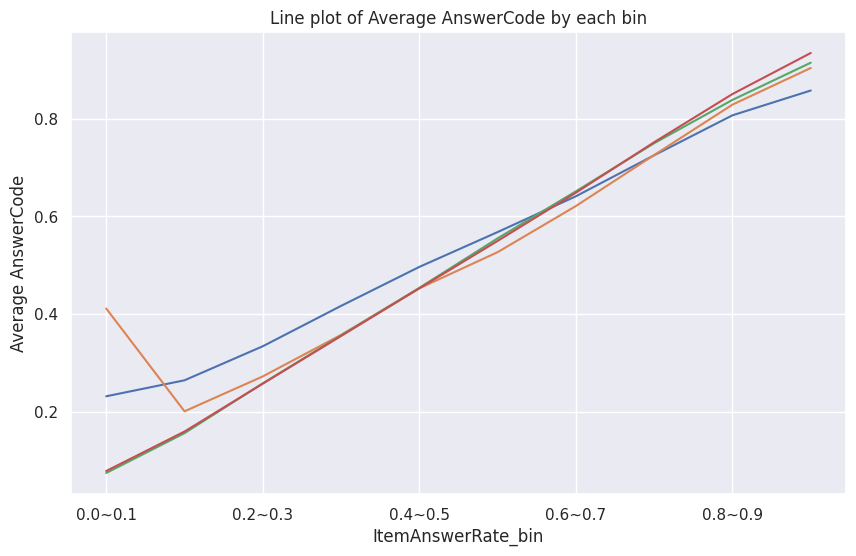

In [22]:
# 이용자의 Timestamp 전까지의 누적 정답률, 문제의 Timestamp 전까지의 누적 정답률, User의 전체 정답률, 문제의 전체 정답률에 따른 정답률
df_copy = df.copy()
columns = ['UserCumulativeAnswerRate', 'ItemCumulativeAnswerRate', 'UserAnswerRate', 'ItemAnswerRate']

plt.figure(figsize=(10, 6))
for column in columns:
    bins = np.linspace(0, 1, 11)
    labels = [f'{i/10}~{(i+1)/10}' for i in range(10)]
    df_copy[column + '_bin'] = pd.cut(df_copy[column], bins, labels=labels, include_lowest=True)
    bin_avg = df_copy.groupby(column + '_bin', observed=True)['answerCode'].mean()
    bin_avg.plot(kind='line', label=column)

plt.ylabel('Average AnswerCode')
plt.title('Line plot of Average AnswerCode by each bin')
plt.legend

## 결과 해석 : 문제별, User별 정답률 데이터는 현재 문제의 정답률을 예측하는 데 있어서 설명력이 굉장히 강하다

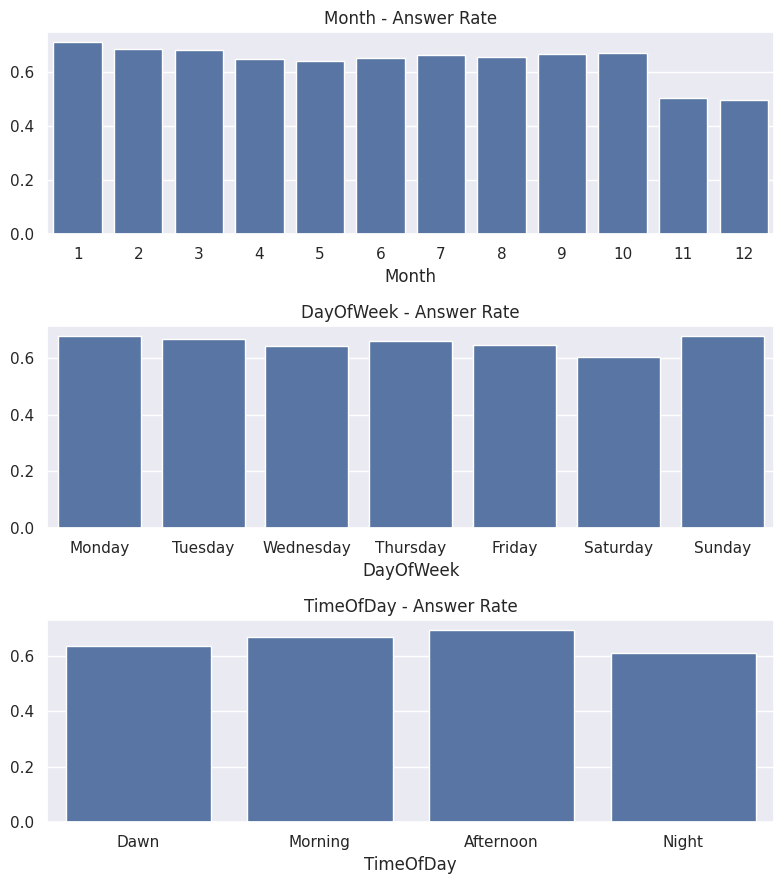

In [19]:
# 각 달에 따른 정답률 계산
month_answer_rate = df.groupby('Month')['answerCode'].mean()

# 각 요일에 따른 정답률 계산
day_answer_rate = df.groupby('DayOfWeek')['answerCode'].mean()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_answer_rate = day_answer_rate.loc[day_order]

# 시간대에 따른 정답률 계산
time_answer_rate = df.groupby('TimeOfDay')['answerCode'].mean()
time_order = ["Dawn", "Morning", "Afternoon", "Night"]
time_answer_rate = time_answer_rate.loc[time_order]
fig, ax = plt.subplots(3, 1, figsize=(8, 9))

sns.barplot(x=month_answer_rate.index, y=month_answer_rate.values, ax=ax[0])
ax[0].set_title('Month - Answer Rate')

sns.barplot(x=day_answer_rate.index, y=day_answer_rate.values, ax=ax[1])
ax[1].set_title('DayOfWeek - Answer Rate')

sns.barplot(x=time_answer_rate.index, y=time_answer_rate.values, ax=ax[2])
ax[2].set_title('TimeOfDay - Answer Rate')

plt.tight_layout()
plt.show()

## 결과 해석 : 11, 12월의 정답률이 눈에 띄게 낮음, 밤과 새벽보단 오전, 오후 정답률이 대체로 높음, 요일은 정답률에 영향을 거의 주지 않음

/tmp/ipykernel_343356/732628558.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_answer_rate = df.loc[time_bin.index].groupby(time_bin)['answerCode'].mean()


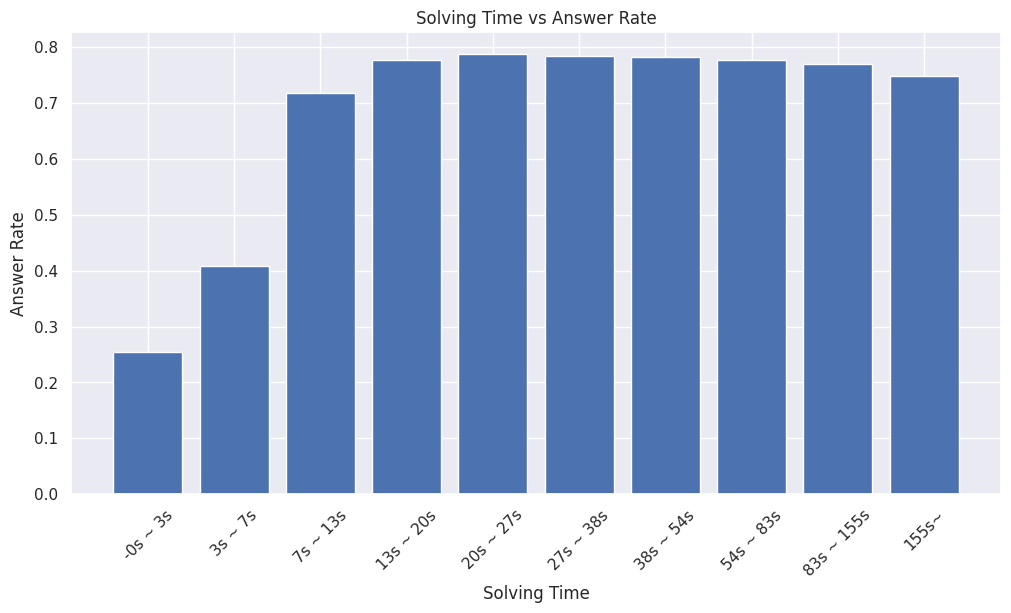

In [18]:
# SolvingTime에 따른 정답률 시각화
df_no_nan = df['SolvingTime'].dropna()
quantiles = df_no_nan.quantile(np.arange(0, 1.1, 0.1)) # 상위 0~10% 풀이시간부터 90~100%까지 10분위로 나눔
time_bin = pd.cut(df_no_nan, bins=quantiles, include_lowest=True)
bin_answer_rate = df.loc[time_bin.index].groupby(time_bin)['answerCode'].mean()
bin_labels = ["{:.0f}s ~ {:.0f}s".format(bin.left, bin.right) for bin in bin_answer_rate.index.categories[:-1]]
bin_labels.append("{:.0f}s~".format(bin_answer_rate.index.categories[-1].left))

plt.figure(figsize=(12, 6))
plt.bar(x=np.arange(len(bin_answer_rate)), height=bin_answer_rate.values, tick_label=bin_labels)
plt.xlabel('Solving Time')
plt.ylabel('Answer Rate')
plt.title('Solving Time vs Answer Rate')
plt.xticks(rotation=45)
plt.show()

## 결과 해석 : 0~7초 (풀이시간 하위 20%)의 풀이 시간을 가질 경우 오답 비율이 굉장히 높았다. 찍었다는 의미 

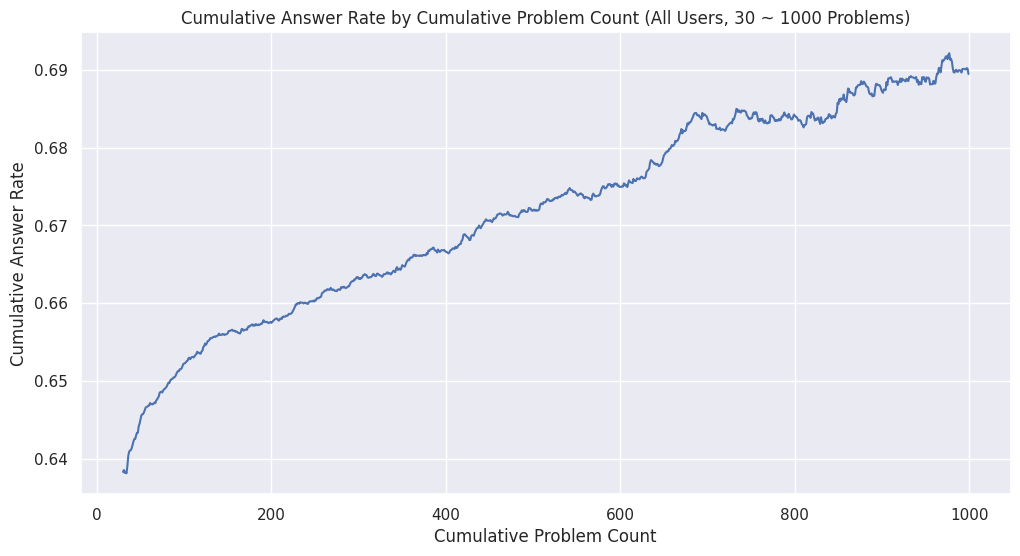

In [20]:
# 누적 풀이 문제수에 따른 정답률 추이 (30문제 이하, 1000문제 이상 제외)
df['CumulativeAnswerRate'] = df.groupby('userID')['answerCode'].transform(lambda x: x.expanding().mean())
df['CumulativeProblemCount'] = df.groupby('userID').cumcount()
selected_df = df[(df['CumulativeProblemCount'] >= 30) & (df['CumulativeProblemCount'] < 1000)]

plt.figure(figsize=(12, 6))
plt.plot(selected_df.groupby('CumulativeProblemCount')['CumulativeAnswerRate'].mean())
plt.xlabel('Cumulative Problem Count')
plt.ylabel('Cumulative Answer Rate')
plt.title('Cumulative Answer Rate by Cumulative Problem Count (All Users, 30 ~ 1000 Problems)')
plt.show()

## 결과 해석 : 누적 문제 풀이 숫자가 증가할수록 대체로 정답률이 의미있게 증가함을 확인

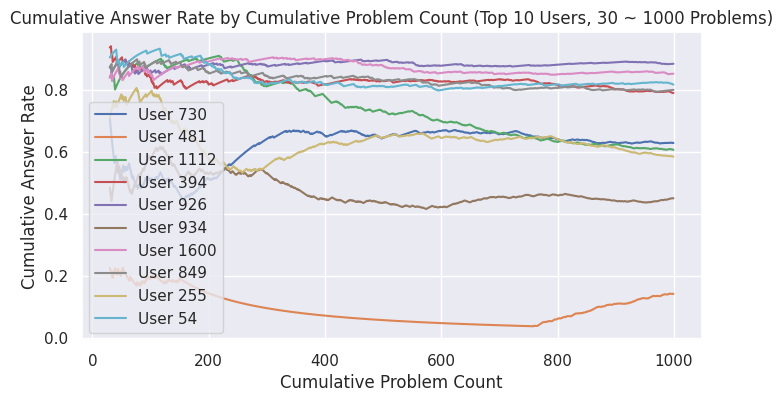

In [26]:
# 문제 풀이 수 상위 10명의 누적 문제풀이 개수별 정답률 추이
top10_users = df['userID'].value_counts().index[:10]

plt.figure(figsize=(8, 4))
for user in top10_users:
    user_df = df[df['userID'] == user]
    selected_user_df = user_df[(user_df['CumulativeProblemCount'] >= 30) & (user_df['CumulativeProblemCount'] < 1000)]
    plt.plot(selected_user_df['CumulativeProblemCount'], selected_user_df['CumulativeAnswerRate'], label='User {}'.format(user))

plt.xlabel('Cumulative Problem Count')
plt.ylabel('Cumulative Answer Rate')
plt.title('Cumulative Answer Rate by Cumulative Problem Count (Top 10 Users, 30 ~ 1000 Problems)')
plt.legend()
plt.show()

## 문제 풀이 수 Top 10 유저들의 누적 문제 풀이 별 누적 정답률 그래프. 위의 그래프와 다르게 상승 경향성을 확인하기 힘들다.

In [24]:
# 'userID'와 'KnowledgeTag'로 그룹화한 후, 각 그룹의 크기(문제 수)를 계산합니다.
grouped = df.groupby(['userID', 'KnowledgeTag']).size()

# 문제 수가 많은 순서대로 정렬하고 상위 10개를 선택합니다.
top_10 = grouped.sort_values(ascending=False).head(10)

print(top_10)

userID  KnowledgeTag
165     2010            108
473     2010             72
165     10169            72
393     2010             72
54      7597             60
1116    7597             60
608     2010             58
1766    7597             57
1079    7597             56
504     7597             56
dtype: int64
